# Can I plot the single-cell tracks and glimpses

Using the outliers that are 1sd away from the mean of dMtb

In [4]:
import os, glob
import btrack
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from macrohet import dataio, tools, visualise
from tqdm.auto import tqdm
from scipy import stats
import pickle
import re
import cv2
from skimage import io
colors = sns.set_palette('PiYG')
track_scale_factor = 5.04

### Load metadata

In [5]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/PS0000/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [6]:
metadata_path = os.path.join(base_dir, 'macrohet_images/PS0000/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Load cells from outlier dMtb analysis

In [7]:
# load glimpses from outliers and extract unique_IDs from them
outlier_fns = glob.glob('/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/*.png')
unique_IDs = [fn.split('_')[2] for fn in outlier_fns]
unique_IDs = list(set(unique_IDs))

In [46]:
unique_IDs[0]

'504.5.5'

In [56]:
# filter unique IDs so that only the GT tracks feature
GT_unique_IDs = list()
for key, info in assay_layout.iterrows():
    row, column = key
    # load track score dict
    track_performance_dict_fn = os.path.join(base_dir, f'upstream_development/tracking/tracking_performance/{row},{column}/({row}, {column})_track_assessment.json')
    with open(track_performance_dict_fn, 'r') as json_file:
        # Load the JSON data into a Python dictionary
        track_performance_dict = json.load(json_file)
        GT_IDs = list({track_id for track_id, value in track_performance_dict.items() if value is True})
        GT_unique_IDs_per_pos = [f'{ID}.{row}.{column}' for ID in GT_IDs]
        GT_unique_IDs += GT_unique_IDs_per_pos

In [62]:
len([unique_ID for unique_ID in unique_IDs if unique_ID in GT_unique_IDs])

106

## Now define new list

In [63]:
unique_IDs = [unique_ID for unique_ID in unique_IDs if unique_ID in GT_unique_IDs]

In [64]:
len(unique_IDs)

106

# Load sc_df

In [65]:
# Specify the path to your pickle file
sc_df_path = os.path.join(base_dir, "results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_interp.pkl" )
#"/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl"

# Load the pickle file
with open(sc_df_path, "rb") as file:
    df = pickle.load(file)

In [70]:
#rename column for ease of use
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

### only use GT tracks for the moment? maybe implement later

In [236]:
gt_track_dict_fn = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/(3, 5)_track_assessment.json'
# Load the JSON data from the file
with open(gt_track_dict_fn, 'r') as file:
    gt_track_dict = json.load(file)
# true_IDs = [f'{int(ID)}.3.5' for ID, status in gt_track_dict.items() if status is True]
true_IDs = [int(ID) for ID, status in gt_track_dict.items() if status is True]
true_unique_IDs = [f'{ID}.3.5' for ID in true_IDs if f'{ID}.3.5' in df['Unique ID'].unique()]#[0:20] #only do 20


# Filter df

In [84]:
# subset_df = df[df['Unique_ID'].isin(true_unique_IDs)] # only GT 3.5 tracks
subset_df = df[df['Unique ID'].isin(unique_IDs)] # all outlier tracks for now

In [85]:
subset_df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID,dMtb
2846,0,358.422546,340.802887,1806.449634,1717.646550,0.0,0.0,0.0,23559.0,363.705963,...,0.748212,0.000000,RD1,CTRL,EC0,1,599,"(3, 4)",599.3.4,0.037397
2847,1,367.434021,332.179840,1851.867466,1674.186394,0.0,0.0,0.0,19520.0,360.849426,...,0.771115,12.472514,RD1,CTRL,EC0,1,599,"(3, 4)",599.3.4,0.037397
2848,2,364.359222,332.559021,1836.370481,1676.097466,0.0,0.0,0.0,9217.0,364.105469,...,0.722586,3.098090,RD1,CTRL,EC0,1,599,"(3, 4)",599.3.4,0.037397
2849,3,367.115234,334.222717,1850.260781,1684.482495,0.0,0.0,0.0,14081.0,362.739166,...,0.494904,3.219237,RD1,CTRL,EC0,1,599,"(3, 4)",599.3.4,0.037397
2850,4,368.795471,335.902924,1858.729175,1692.950735,0.0,0.0,0.0,15457.0,361.607544,...,0.563498,2.376192,RD1,CTRL,EC0,1,599,"(3, 4)",599.3.4,0.037397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296703,70,1067.297852,526.372009,5379.181172,2652.914927,0.0,0.0,0.0,15163.0,379.367615,...,0.718302,2.180501,WT,BDQ,EC99,2,817,"(6, 9)",817.6.9,0.356070
296704,71,1069.588867,529.066589,5390.727891,2666.495610,0.0,0.0,0.0,14540.0,381.305084,...,0.822753,3.536879,WT,BDQ,EC99,2,817,"(6, 9)",817.6.9,0.356070
296705,72,1066.842773,528.806946,5376.887578,2665.187007,0.0,0.0,0.0,16567.0,380.380341,...,0.796328,2.758341,WT,BDQ,EC99,2,817,"(6, 9)",817.6.9,0.356070
296706,73,1070.047241,530.092041,5393.038096,2671.663887,0.0,0.0,0.0,16485.0,378.513733,...,0.705223,3.452547,WT,BDQ,EC99,2,817,"(6, 9)",817.6.9,0.356070


# Animating these graphs (making interactive)

In [68]:
from bokeh.models import HoverTool, WheelZoomTool, Label
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook, reset_output, save
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.layouts import gridplot
from bokeh.models import Range1d

import matplotlib.cm as cm

output_notebook()


Loading BokehJS ...

### Set colour codes

In [74]:
subset_df['dmtb colour codes'] = subset_df['dMtb'].apply(lambda x: cm.PiYG((x - subset_df['dMtb'].min()) / (subset_df['dMtb'].max() - subset_df['dMtb'].min())))
subset_df['dmtb colour codes'] = subset_df['dmtb colour codes'].apply(lambda x: matplotlib.colors.to_hex(x))

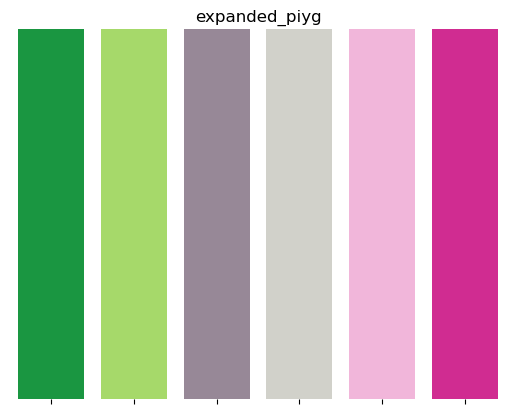

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [75]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

expanded_piyg_dict = {
                      'WT':expanded_piyg[0], 
                      'RD1':expanded_piyg[-1],
                      'BDQ':expanded_piyg[0], 
                      'INH':expanded_piyg[1], 
                      'PZA':expanded_piyg[4], 
                      'RIF':expanded_piyg[5]}

# Plot Mtb time series

In [76]:
output_dir = os.path.join(base_dir, 'results/interactive_plots/time_series')

In [86]:
# Create a new column 'glimpse_url' with default values of None
subset_df['glimpse_url'] = None

# Iterate over the rows of the subset_df DataFrame
for index, row_ in tqdm(subset_df.iterrows(), total = len(subset_df)):
    unique_ID = row_['Unique ID']
    time = row_['Time (hours)']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/time_series/all_glimpses/glimpse_{unique_ID}_t{time}.png'
    subset_df.at[index, 'glimpse_url'] = online_fn

  0%|          | 0/7366 [00:00<?, ?it/s]

In [87]:
# Configure the hover tool for tooltips
hover = HoverTool(
    tooltips="""
        <div>
            <div style="width: 120px; height: 120px; overflow: hidden;">
                <img
                    src="@glimpse_url" height="120" alt="@glimpse" width="120"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                >
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Mtb measure (pixel int.): @y</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Time (hours): @x</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Area: @area</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Mtb Strain: @strain</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Compound: @compound</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Technical replicate #: @tech_rep</span>
            </div>
        </div>
    """
)

In [88]:
# define a window size for the rolling average calculation in time series smoothing
window_size = 7

# define three figures
plots = list()
used_IDs = list()

# set a counter to see what the maximum y value across all plots is
y_max = float('-inf')

# iterate over different drug concentrations to plot each individually
for conc in tqdm(['EC99', 'EC50', 'EC0']):
    
    # filter only set experiment concentration from main df
    expt_df = subset_df[subset_df['Concentration']==conc]
    
    # define three figures iteratively
    p = figure(title=f'Drug concentration: {conc}',
                height = int(1080*0.3),
                tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
                width = int(1920*0.4))
    
    # add scroll control 
    p.toolbar.active_scroll = p.select_one(WheelZoomTool)
#     p.add_tools(PanTool())
    
    # title axes
    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Mtb'
    
    # initialise cell counter
    counter=0
    
    # iterate over cell IDs
    for ID in unique_IDs:
        
        # limit the number of cells per experiment 
        if counter > 10:
            continue
            
        # if this cell ID doesnt belong to this experiment then skip
        if ID not in expt_df['Unique ID'].values:
            continue
            
        # trying to figure how many sc measurements 
        counter+=1

        # filter single-cell information from experiment dataframe 
        ID_df = expt_df[expt_df['Unique ID']==ID]
        
#         # get a color code that is related to the change in Mtb over cell lifetime
#         color = ID_df['dmtb colour codes'].iloc[0]
        
        # get the experiment info for the legend key
        strain = ID_df['Strain'].iloc[0]
        compound = ID_df['Compound'].iloc[0]
        concentration = ID_df['Concentration'].iloc[0]
        label = f'{strain}, {compound}, {concentration}'
        
        # get max y value for single-cell df
        y_max = max(y_max, ID_df['Intracellular thresholded Mtb content'].rolling(window=window_size, min_periods=1).mean().max())

        # input data as CDS
        source = ColumnDataSource(
                                    name='data_source',
                                    data=dict(
                                    x=ID_df['Time (hours)'],
                                    x_shift=ID_df['Time (hours)']+int(window_size/2),
                                    y=ID_df['Intracellular thresholded Mtb content'].rolling(window=window_size, min_periods=1).mean(),
                                    y_raw=ID_df['Intracellular thresholded Mtb content'],
                                    glimpse_url=ID_df['glimpse_url'],
                                    area=ID_df['Area'],
                                    dMtb=ID_df['dMtb'], 
                                    cell_ID=ID_df['Cell ID'], 
                                    strain=ID_df['Strain'],
                                    compound=ID_df['Compound'],
                                    concentration=ID_df['Concentration'],
                                    tech_rep=ID_df['Technical replicate']
                                    ))
        
        # change the colormap key if differentiating between ctrl expts
        if compound != 'CTRL':
            color = expanded_piyg_dict[compound]
        else:
            color = expanded_piyg_dict[strain]
        
        # firstly plot the raw data
        p.line(source=source,
               x='x_shift', # to align with rolling average 
               y='y_raw',
               color=color, 
               line_width=2, 
               alpha=0.5,
               muted = True,
               muted_color=color, 
               muted_alpha=0.0, 
               muted_line_width=1,
               legend_label='Raw data',
               line_dash = 'dashed'
              )
        
        # secondly plot the smoothed data
        p.line(source=source,
               x='x', 
               y='y',
               color=color, 
               line_width=5, 
               alpha=0.88,
               muted_color=color, 
               muted_alpha=0.2, 
               muted_line_width=1,
               legend_label=label,
              )

    

    # add hover tool
    p.add_tools(hover)

    # define where legends should be
    p.legend.location = "top_left"
    p.legend.click_policy="mute"
    
    # group plots together
    plots.append(p)

# update plots with y_range calibrated to max value over 
for p in plots:
    p.y_range = Range1d(start=0, end=y_max*1.1)

# plot horizontally
plot = gridplot([[p] for p in plots])

# # save output as html
output_file(os.path.join(output_dir, "mtb_time_series_GT_70.html"), title="Single-cell tracks")

# show plot
show(plot)

  0%|          | 0/3 [00:00<?, ?it/s]

# WIP: GIF

In [83]:
unique_IDs.remove('673.3.5' )

In [82]:
'673.3.5' in unique_IDs

True

In [ ]:
import imageio

images = []
for filename in filenames:  # filenames is a list of paths to the images
    images.append(imageio.imread(filename))
imageio.mimsave('movie.gif', images, duration=0.5)  # adjust duration as needed


# WIP: taptool to display single cell plot

In [63]:
from bokeh.models import CustomJS, ColumnDataSource, TapTool
from bokeh.plotting import figure, show
from bokeh.layouts import row

# ... your other code ...

# Create an empty ColumnDataSource that will be used to display selected line in second plot
selected_source = ColumnDataSource(data=dict(x=[], y=[], y_raw=[]))

p1 = figure(title=f'Drug concentration: {conc}',
            plot_height=int(1080*0.3),
            tools='pan,wheel_zoom,box_zoom,reset,tap',
            plot_width=int(1920*0.4))

p2 = figure(width=400, height=400, x_range=p1.x_range, y_range=p1.y_range, title="Selected line")

# Line on second plot
p2.line(x='x', y='y', source=selected_source, line_width=4, line_color="orange")

# Store the lines and their sources in dictionaries so we can access them by ID later
lines = {}
sources = {}

# iterate over cell IDs
for idx, ID in enumerate(unique_IDs):
    # if this cell ID doesnt belong to this experiment then skip
    if ID not in expt_df['Unique ID'].values:
        continue

    # filter single-cell information from experiment dataframe 
    ID_df = expt_df[expt_df['Unique ID']==ID]
    # ... the rest of your existing code ...

    # plot the line on p1 and store the line and source with their ID
    line = p1.line(x='x', y='y', source=source, line_width=4, line_color=color)
    lines[str(idx)] = line
    sources[str(idx)] = source

# TapTool callback
callback = CustomJS(args=dict(lines=lines, sources=sources, selected_source=selected_source), code="""
    // Get the index of the selected glyph
    var selected_index = cb_data.source.selected.indices[0];

    // Get the source of the selected glyph
    var selected_source = sources[String(selected_index)];

    // Copy the data to the selected_source
    selected_source.data = selected_source.data;
""")

# Add the callback to the TapTool
tap_tool = p1.select(type=TapTool)
tap_tool.callback = callback

# Arrange the plots in a layout
layout = row(p1, p2)

# Show the plot
show(layout)


# WIP: display N trajectories

In [52]:
# your imports
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.models.widgets import Spinner
from bokeh.layouts import column
from bokeh.transform import factor_cmap
from bokeh.palettes import Viridis256
from bokeh.models import FactorRange

# other parts of your code ...

p = figure(title=f'Drug concentration: {conc}',
                plot_height = int(1080*0.3),
                tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
                plot_width = int(1920*0.4))

# initialise cell counter
counter = 0

# create an empty list to store the lines
lines = []

# iterate over cell IDs
for ID in tqdm(unique_IDs, total = len(unique_IDs)):
    
#     if counter > 30:
#         continue

    # if this cell ID doesnt belong to this experiment then skip
    if ID not in expt_df['Unique ID'].values:
        continue

    # filter single-cell information from experiment dataframe 
    ID_df = expt_df[expt_df['Unique ID']==ID]

    # get the experiment info for the legend key
    strain = ID_df['Strain'].iloc[0]
    compound = ID_df['Compound'].iloc[0]
    concentration = ID_df['Concentration'].iloc[0]
    label = f'{strain}, {compound}, {concentration}'

    # get max y value for single-cell df
    y_max = max(y_max, ID_df['Intracellular thresholded Mtb content'].rolling(window=window_size, min_periods=1).mean().max())

    # input data as CDS
    source = ColumnDataSource(
                                name='data_source',
                                data=dict(
                                x=ID_df['Time (hours)'],
                                x_shift=ID_df['Time (hours)']+int(window_size/2),
                                y=ID_df['Intracellular thresholded Mtb content'].rolling(window=window_size, min_periods=1).mean(),
                                y_raw=ID_df['Intracellular thresholded Mtb content'],
                                glimpse_url=ID_df['glimpse_url'],
                                area=ID_df['Area'],
                                dMtb=ID_df['dMtb'], 
                                cell_ID=ID_df['Cell ID'], 
                                strain=ID_df['Strain'],
                                compound=ID_df['Compound'],
                                concentration=ID_df['Concentration'],
                                tech_rep=ID_df['Technical replicate']
                                ))

    # change the colormap key if differentiating between ctrl expts
    if compound != 'CTRL':
        color = expanded_piyg_dict[compound]
    else:
        color = expanded_piyg_dict[strain]

    # plot the line and add it to the lines list
    line = p.line(x='x', y='y', source=source, line_width=4, line_color=color, visible=False)
    lines.append(line)

    # increment the counter
    counter += 1

# Create a spinner and set up the callback
spinner = Spinner(title="Number of trajectories to display", low=1, high=len(lines), step=1, value=10, width=80)
callback = CustomJS(args=dict(lines=lines, spinner=spinner), code="""
    for (let i = 0; i < lines.length; i++) {
        lines[i].visible = i < spinner.value;
    }
""")
spinner.js_on_change("value", callback)

# other parts of your code ...

# Arrange plots and widgets in a layout
layout = column(spinner, p)

# show layout
show(layout)


  0%|          | 0/332 [00:00<?, ?it/s]

In [26]:
import numpy as np

from bokeh.io import show
from bokeh.layouts import column, row
from bokeh.models import Spinner
from bokeh.plotting import figure

# x = np.random.rand(10)
# y = np.random.rand(10)

# p = figure(x_range=(0, 1), y_range=(0, 1))
# points = p.scatter(x=x, y=y, size=4)

In [ ]:
# define a window size for the rolling average calculation in time series smoothing
window_size = 7

# define three figures
plots = list()
used_IDs = list()

# set a counter to see what the maximum y value across all plots is
y_max = float('-inf')

# iterate over different drug concentrations to plot each individually
for conc in tqdm(['EC99', 'EC50', 'EC0']):
    
    # filter only set experiment concentration from main df
    expt_df = subset_df[subset_df['Concentration']==conc]
    
    # define three figures iteratively
    p = figure(title=f'Drug concentration: {conc}',
                plot_height = int(1080*0.3),
                tools = 'crosshair,save,pan,box_zoom,reset,wheel_zoom,hover', 
                plot_width = int(1920*0.4))
    
    # add scroll control 
    p.toolbar.active_scroll = p.select_one(WheelZoomTool)
#     p.add_tools(PanTool())
    
    # title axes
    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Mtb'
    
    # initialise cell counter
    counter=0
    
    # iterate over cell IDs
    for ID in unique_IDs:
        
        # limit the number of cells per experiment 
        if counter > 10:
            continue
            
        # if this cell ID doesnt belong to this experiment then skip
        if ID not in expt_df['Unique ID'].values:
            continue
            
        # trying to figure how many sc measurements 
        counter+=1

        # filter single-cell information from experiment dataframe 
        ID_df = expt_df[expt_df['Unique ID']==ID]
        
#         # get a color code that is related to the change in Mtb over cell lifetime
#         color = ID_df['dmtb colour codes'].iloc[0]
        
        # get the experiment info for the legend key
        strain = ID_df['Strain'].iloc[0]
        compound = ID_df['Compound'].iloc[0]
        concentration = ID_df['Concentration'].iloc[0]
        label = f'{strain}, {compound}, {concentration}'
        
        # get max y value for single-cell df
        y_max = max(y_max, ID_df['Intracellular thresholded Mtb content'].rolling(window=window_size, min_periods=1).mean().max())

        # input data as CDS
        source = ColumnDataSource(
                                    name='data_source',
                                    data=dict(
                                    x=ID_df['Time (hours)'],
                                    x_shift=ID_df['Time (hours)']+int(window_size/2),
                                    y=ID_df['Intracellular thresholded Mtb content'].rolling(window=window_size, min_periods=1).mean(),
                                    y_raw=ID_df['Intracellular thresholded Mtb content'],
                                    glimpse_url=ID_df['glimpse_url'],
                                    area=ID_df['Area'],
                                    dMtb=ID_df['dMtb'], 
                                    cell_ID=ID_df['Cell ID'], 
                                    strain=ID_df['Strain'],
                                    compound=ID_df['Compound'],
                                    concentration=ID_df['Concentration'],
                                    tech_rep=ID_df['Technical replicate']
                                    ))
        
        # change the colormap key if differentiating between ctrl expts
        if compound != 'CTRL':
            color = expanded_piyg_dict[compound]
        else:
            color = expanded_piyg_dict[strain]
        
        # firstly plot the raw data
        p.line(source=source,
               x='x_shift', # to align with rolling average 
               y='y_raw',
               color=color, 
               line_width=2, 
               alpha=0.5,
               muted = True,
               muted_color=color, 
               muted_alpha=0.0, 
               muted_line_width=1,
               legend_label='Raw data',
               line_dash = 'dashed'
              )
        
        # secondly plot the smoothed data
        smooth_data = p.line(source=source,
               x='x', 
               y='y',
               color=color, 
               line_width=5, 
               alpha=0.88,
               muted_color=color, 
               muted_alpha=0.2, 
               muted_line_width=1,
               legend_label=label,
              )

    

    # add hover tool
    p.add_tools(hover)

    # define where legends should be
    p.legend.location = "top_left"
    p.legend.click_policy="mute"
    
#     spinner = Spinner(title="Glyph size", low=1, high=100, step=1, value=10, width=80)
#     spinner.js_link('value', smooth_data.glyph, 'cell_ID')
    
    # group plots together
    plots.append(p)

# update plots with y_range calibrated to max value over 
for p in plots:
    p.y_range = Range1d(start=0, end=y_max*1.1)

# plot horizontally
plot = gridplot([[p] for p in plots])

# # save output as html
# output_file(os.path.join(output_dir, "mtb_time_series.html"), title="Single-cell tracks")




show(row(column(spinner, width=100), p))

# show plot
show(plot)